# Monte Carlo Predictive coding demo for unsupervised/generative learning 

This notebook demonstrates how to train a Monte Carlo predictive coding (MCPC) model with one input x_0 and one latent state x_1. This network is illustrated below. (a) shows the equivalent generative model and (b) shows the local implementation of PC.

<div style="text-align:center">
    <img src="src/simple_model.png" alt="Image Description" width="600">
</div>


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import predictive_coding as pc

Define utility functions

In [23]:
# This function define the loss function of the input layer of the model. 
# The loss function of the other layers is define in the model definition.
def fe_fn(output, _target):
    return 0.5*(output - _target).pow(2).sum()

# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(torch.Tensor(1,out_features), requires_grad=True)

        # Initialize bias
        nn.init.xavier_normal_(self.bias)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same

# function to initialize the activity of latent layers before inference
def sample_x_fn(inputs):
    return torch.randn_like(inputs['mu'])

# function to add noise to the inference dynamics of the PC layers
def random_step(t, _trainer, var=2.):
    """
        var: sets the variance of the noise.
    """
    xs = _trainer.get_model_xs()
    optimizer = _trainer.get_optimizer_x()
    for x in xs:
        x.grad.normal_(0.,np.sqrt(var/optimizer.defaults['lr']))
    optimizer.step()


Define MCPC model

In [24]:
# network parameters
hidden_size = 1     # number of latent variables in latent layer
output_size = 1     # number of dimensions in data 
    
# create MCPC model    
mcpc_model = nn.Sequential(
    BiasLayer(1),
    pc.PCLayer(sample_x_fn=sample_x_fn),
    nn.Linear(hidden_size, output_size, bias=False),
)
mcpc_model.train()  # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass 

# initialize the prior mean \mu and the weight W_0
nn.init.constant_(mcpc_model[0].bias, 1.)
out = nn.init.constant_(mcpc_model[2].weight, 7.) 


Define trainer that manages the inferences and weight updates of the PC models

In [25]:
T_mixing = 150                      # number of MCPC inference iterations to get to steady state activity
T_sampling = 1                      # number of inference iterations to sample from the posterior distribution
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD          # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.01}   # optimizer parameters for latent state x
update_p_at = 'never'               # update parameters p at the last iteration
optimizer_p_fn = optim.SGD          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.001, 'momentum':0.1} # optimizer parameters for p
plot_progress_at = "all"            # plot progress every inference iterations

inference_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing+T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

Perform an example inference.

The plots shows change over time during inference of the prediction error of the inputs layer in the left panel, the error of the latent layer in the middle panel and the total error of the network in the right panel.

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/151 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_checking_after_callback_after_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| l: 1.464e+03 | e: 5.208e+01 | o: 1.516e+03 |:   0%|          | 0/151 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: 

<Figure size 640x480 with 0 Axes>

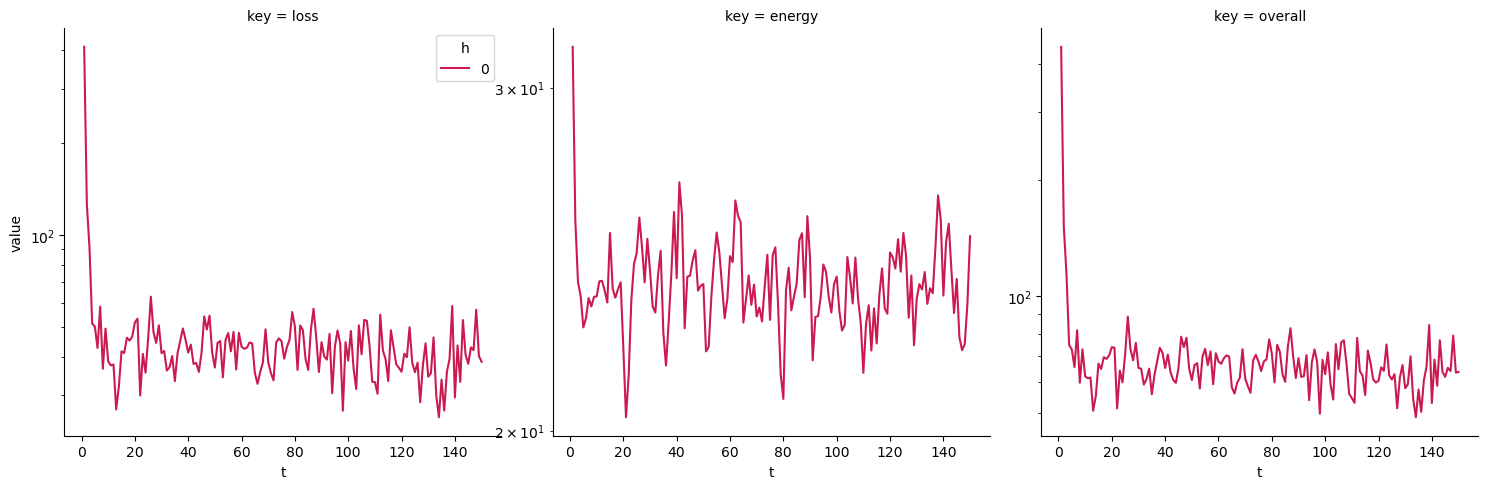

<Figure size 640x480 with 0 Axes>

In [26]:
y = torch.ones(64, output_size) # target data
pseudo_input = torch.zeros(64, 1) # This data is only used to set the batch_size of the PCLayers.
# perform inference
output = inference_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, callback_after_t=random_step, callback_after_t_kwargs={'_trainer':inference_trainer}, is_log_progress=True, is_return_results_every_t=True)

### Train the model

Update trainer for learning

In [27]:
training_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing + T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "last",                       # update when parameters are updated to enable learning    
    accumulate_p_at=[i + T_mixing for i in range(T_sampling)],  # accumulate the gradients of the parameters during all the sampling iterations
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at = []                  # remove plotting to improve inference speed
)

Generate training set as samples from a normal distribution

In [28]:
# data parameters
mu=1.               # data mean
var=5.              # data variance
batch_size = 256    
n = 150              # number of batches

# generate data
data = [mu + np.sqrt(var)*torch.randn(batch_size, output_size) for i in range(n)]

In [29]:
n_epochs = 3   # set number of epochs for training

# train pc model
energy=[np.inf]       # stored overall energy after each iteration
for idx_epoch in range(n_epochs):
    for i, y in enumerate(pbar := tqdm(data, desc=f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")):
        pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
        output = training_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, callback_after_t=random_step, callback_after_t_kwargs={'_trainer':training_trainer}, is_log_progress=False, is_return_results_every_t=False, is_return_outputs=True, is_checking_after_callback_after_t=False)
        energy += output["overall"]
        # Update the tqdm description
        pbar.set_description(f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")
        

Epoch: 3, Energy: 290.61: 100%|██████████| 150/150 [00:08<00:00, 17.38it/s]


### Assess the leanring performance of the model

MCPC's dynamics can also be used to generate from the learned data distributions

In [30]:
# add input PC layer x_0 to model 
model_generation = nn.Sequential(
    mcpc_model[:],
    pc.PCLayer(sample_x_fn=sample_x_fn)
)
model_generation.train()    # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass

# setup trainer for generation with large T to get close to the true generative distribution
generation_trainer = pc.PCTrainer(model_generation, 
    T = 10000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = {"lr":0.01},
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| e: 3.082e+02 | o: 3.082e+02 |:   0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| e: 8.605e+01 | o: 8.605e+01 |: 100%|██████████| 10000/10000 [00:21<00:00, 472.95it/s]
c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predi

<Figure size 640x480 with 0 Axes>

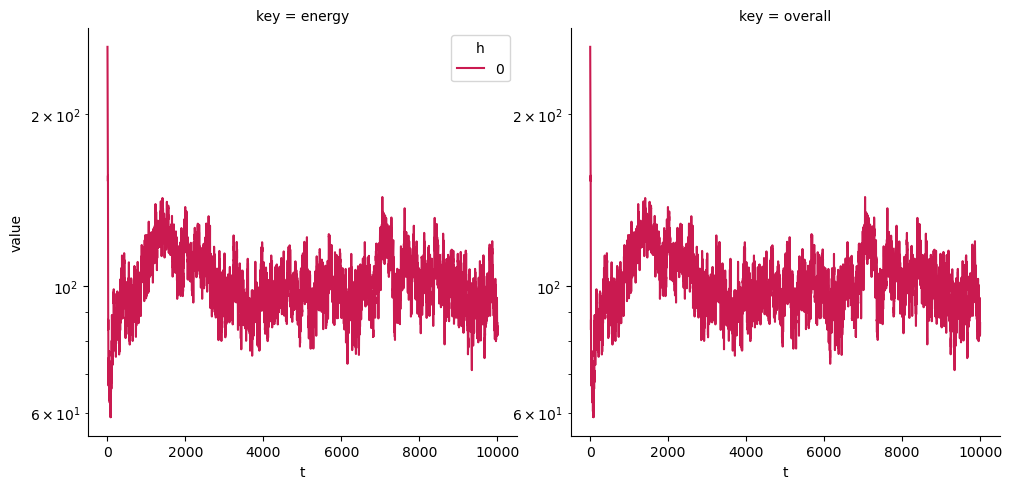

<Figure size 640x480 with 0 Axes>

In [31]:
# run generation with neural network/dynamics
pseudo_input = torch.zeros(100, 1) # This data is only used to set the batch_size of the PCLayers
results = generation_trainer.train_on_batch(inputs=pseudo_input, callback_after_t=random_step, callback_after_t_kwargs={'_trainer':generation_trainer}, is_return_results_every_t=True, is_return_outputs = True, is_checking_after_callback_after_t=False)

# extract activity of PC layer x_0 over time
x_0 = [x_0 for x_0 in results["outputs"]]

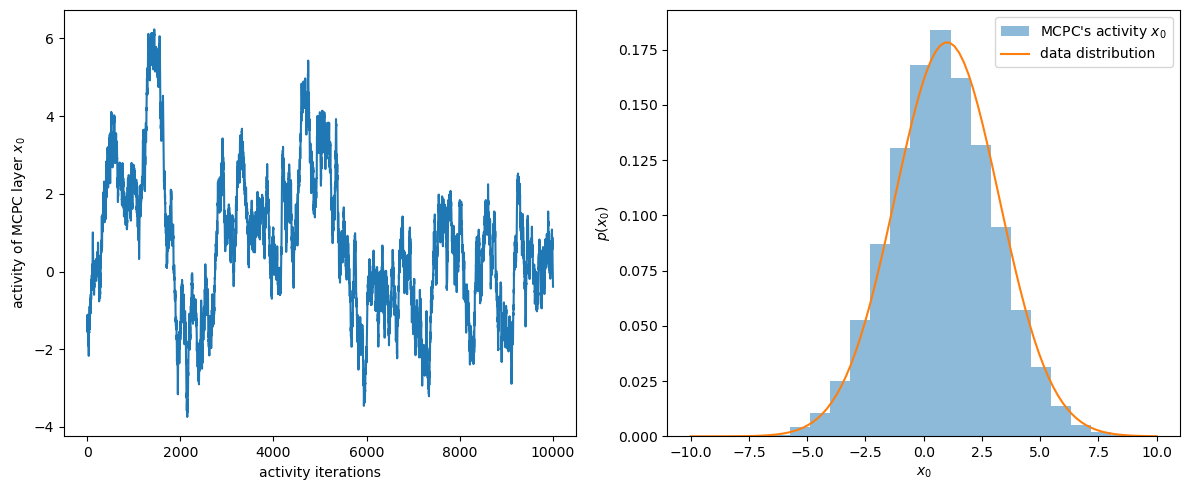

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([x[0,0].item() for x in x_0])
plt.xlabel("activity iterations")
plt.ylabel(r"activity of MCPC layer $x_0$")

# plot histogram of generated data
plt.subplot(1,2,2)
plt.hist(torch.cat(x_0).reshape(-1).detach().numpy(), bins=20, alpha=0.5, label=r"MCPC's activity $x_0$ ", density=True)
# plot data distribution
x = np.linspace(-10,10,100)
plt.plot(x, 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x - mu)**2/var), label="data distribution")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p(x_0)$")
plt.legend()
plt.tight_layout()